In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import datetime

!rm -rf ./logs/
%load_ext tensorboard

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
 print(tf.__version__)

2.0.0-rc1


In [3]:
df = pd.read_csv("./car.csv")

In [4]:
dataset= df.copy()
dataset = df[['Engine HP', 'MSRP']] 
dataset.head()

,Engine HP,MSRP
0,335.0,46135
1,300.0,40650
2,300.0,36350
3,230.0,29450
4,230.0,34500


In [5]:
dataset.isnull().values.any() #Check whether there is NULL value

True

In [6]:
dataset.shape

(11914, 2)

In [7]:
dataset.isna().sum()

Engine HP    69
MSRP          0
dtype: int64

In [8]:
dataset = dataset.dropna()  #to drop na values

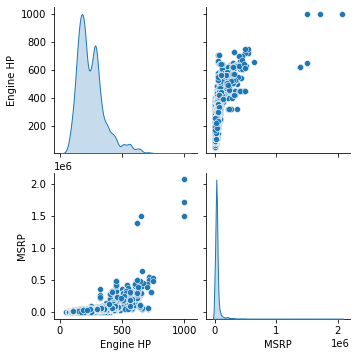

In [9]:
sns.pairplot(dataset[['Engine HP', 'MSRP']], diag_kind='kde')

In [10]:
dataset = dataset[dataset['Engine HP']<800]   #Removing outliers
dataset.shape

(11842, 2)

In [11]:
#Removing outliers using IQR rule
def calc_limits(feature):
    q1,q3=dataset[feature].quantile([0.25,0.75])
    iqr=q3-q1
    rang=1.5*iqr
    return(q1-rang,q3+rang)
for col in dataset.columns:
    lower,upper=calc_limits(col)
    dataset = dataset[(dataset[col] >lower) & (dataset[col]<upper)]

In [12]:
X=dataset['Engine HP'].values
Y=dataset['MSRP'].values
train_index = np.random.choice(len(X), round(len(X) * 0.7), replace=False) #train-test split
test_index = np.array(list(set(range(len(X))) - set(train_index)))
x_train = X[train_index]
y_train = Y[train_index]
x_test = X[test_index]
y_test = Y[test_index]

In [13]:
#Normalised the dataset
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)
x_train = min_max_normalized(x_train)
x_test = min_max_normalized(x_test)
y_train = min_max_normalized(y_train)
y_test = min_max_normalized(y_test)
x_train = tf.constant( x_train , dtype=tf.float32 )
y_train = tf.constant( y_train , dtype=tf.float32 ) 
                                                          
x_test = tf.constant( x_test , dtype=tf.float32 ) 
y_test = tf.constant( y_test , dtype=tf.float32 ) 

In [14]:
def mean_squared_error( Y , y_pred ):  #loss function
    return tf.reduce_mean( tf.square( y_pred - Y ) )

def mean_squared_error_deriv( Y , y_pred ):  #optimizer
    return tf.reshape( tf.reduce_mean( 2 * ( y_pred - Y ) ) , [ 1 , 1 ] )
    
def h( X , weights , bias ):  
    return tf.add(tf.multiply(weights, X), bias)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/mean_squared_error_deriv/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [15]:
#hyperparameters
num_epochs = 1000
num_samples = x_train.shape[0]
batch_size = 10
learning_rate = 0.001

dataset = tf.data.Dataset.from_tensor_slices(( x_train , y_train )) 
dataset = dataset.shuffle( 500 ).repeat( num_epochs ).batch( batch_size )
iterator = dataset.__iter__()


In [ ]:
weights = tf.random.normal( ( 1 , 1 ) ) 
bias = 0
for epoch in range( num_epochs ) : 
    epoch_loss = list()
    for i in range( int(num_samples/batch_size) ):
        x_batch , y_batch = iterator.get_next()
   
        output = h( x_batch , weights , bias ) 
        loss = epoch_loss.append( mean_squared_error( y_batch , output ).numpy() )
        loss1 = mean_squared_error( y_batch , output )
    
        dJ_dH = mean_squared_error_deriv( y_batch , output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean( dJ_dH * dH_dW )
        dJ_dB = tf.reduce_mean( dJ_dH )
    
        weights -= ( learning_rate * dJ_dW )
        bias -= ( learning_rate * dJ_dB ) 
        
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', loss1, step=epoch)
        
     
        
    loss = np.array( epoch_loss ).mean()
    if (epoch + 1) % 50 == 0: 
        print( 'Loss is {}'.format( loss ) )  

Loss is 0.030441123992204666
Loss is 0.028746554628014565
Loss is 0.027618493884801865
Loss is 0.026782609522342682
Loss is 0.026457998901605606
Loss is 0.025964777916669846
Loss is 0.02602461539208889
Loss is 0.025843489915132523
Loss is 0.02583351917564869
Loss is 0.02586326003074646
Loss is 0.02536211535334587
Loss is 0.025723526254296303


In [ ]:
weights.numpy(), bias.numpy()

In [ ]:
y_pred = h( x_test , weights , bias )
print('MSE is {}'.format(mean_squared_error( y_test , y_pred )))

In [ ]:
sse = tf.reduce_sum(tf.square(y_test - y_pred))
sst = tf.reduce_sum(tf.square(y_test -  tf.reduce_mean(y_test)))
r2 = tf.subtract(1.0, tf.math.divide(sse,sst))
print("R2: {}" .format(r2))

In [ ]:
%tensorboard --logdir logs/mean_squared_error_deriv/